# 🎮 1D Playground: Diffusion & Flow Matching Sanity Checks

This notebook provides interactive 1D experiments to build intuition for diffusion models and flow matching.

**Why 1D?**
- Ultra-fast training (in seconds & CPU friendly)
- Easy to visualize distributions and flows
- Perfect for debugging and understanding

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Create 1D Mixture of Gaussians

In [3]:
def get_1d_data(name, n_samples=10000):
    """Generate 1D mixture of Gaussians datasets with different weights."""
    if name == '2gaussians':
        # Two Gaussians at -2 and 2 (equal weights)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        # Three Gaussians at -2, 0, 2 (equal weights)
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        # Five evenly spaced Gaussians (equal weights)
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        # Uneven mixture with different spacing (equal weights)
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        # Wider Gaussians (equal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        # Two Gaussians with different weights (tall left, short right)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        # Three Gaussians with different weights (tall-short-medium)
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        # Five Gaussians with varied weights
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        # Wider Gaussians (unequal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Sample from each Gaussian according to weights
    X = []
    for center, weight in zip(centers, weights):
        n_samples_for_center = int(n_samples * weight)
        samples = np.random.randn(n_samples_for_center, 1) * std + center
        X.append(samples)
    X = np.concatenate(X, axis=0)
    
    # Shuffle
    np.random.shuffle(X)
    
    return torch.tensor(X, dtype=torch.float32)


def get_ground_truth_density(name, x_values):
    """Compute the ground truth density for a given dataset at x_values."""
    if name == '2gaussians':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Compute mixture of Gaussians density
    density = np.zeros_like(x_values)
    for center, weight in zip(centers, weights):
        density += weight * (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - center) / std) ** 2)
    
    return density

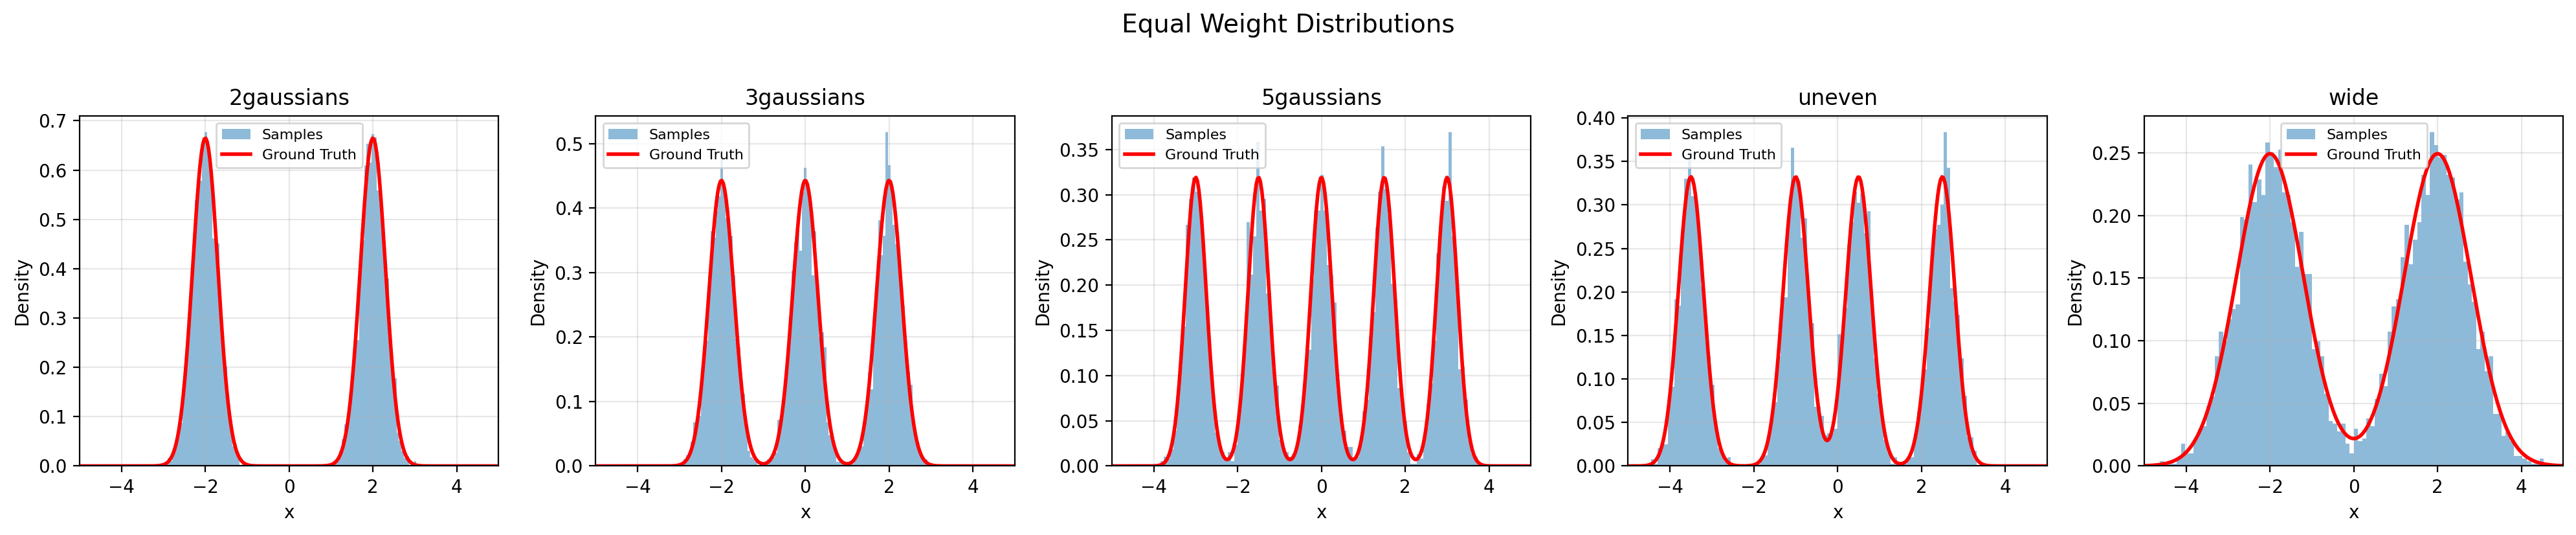

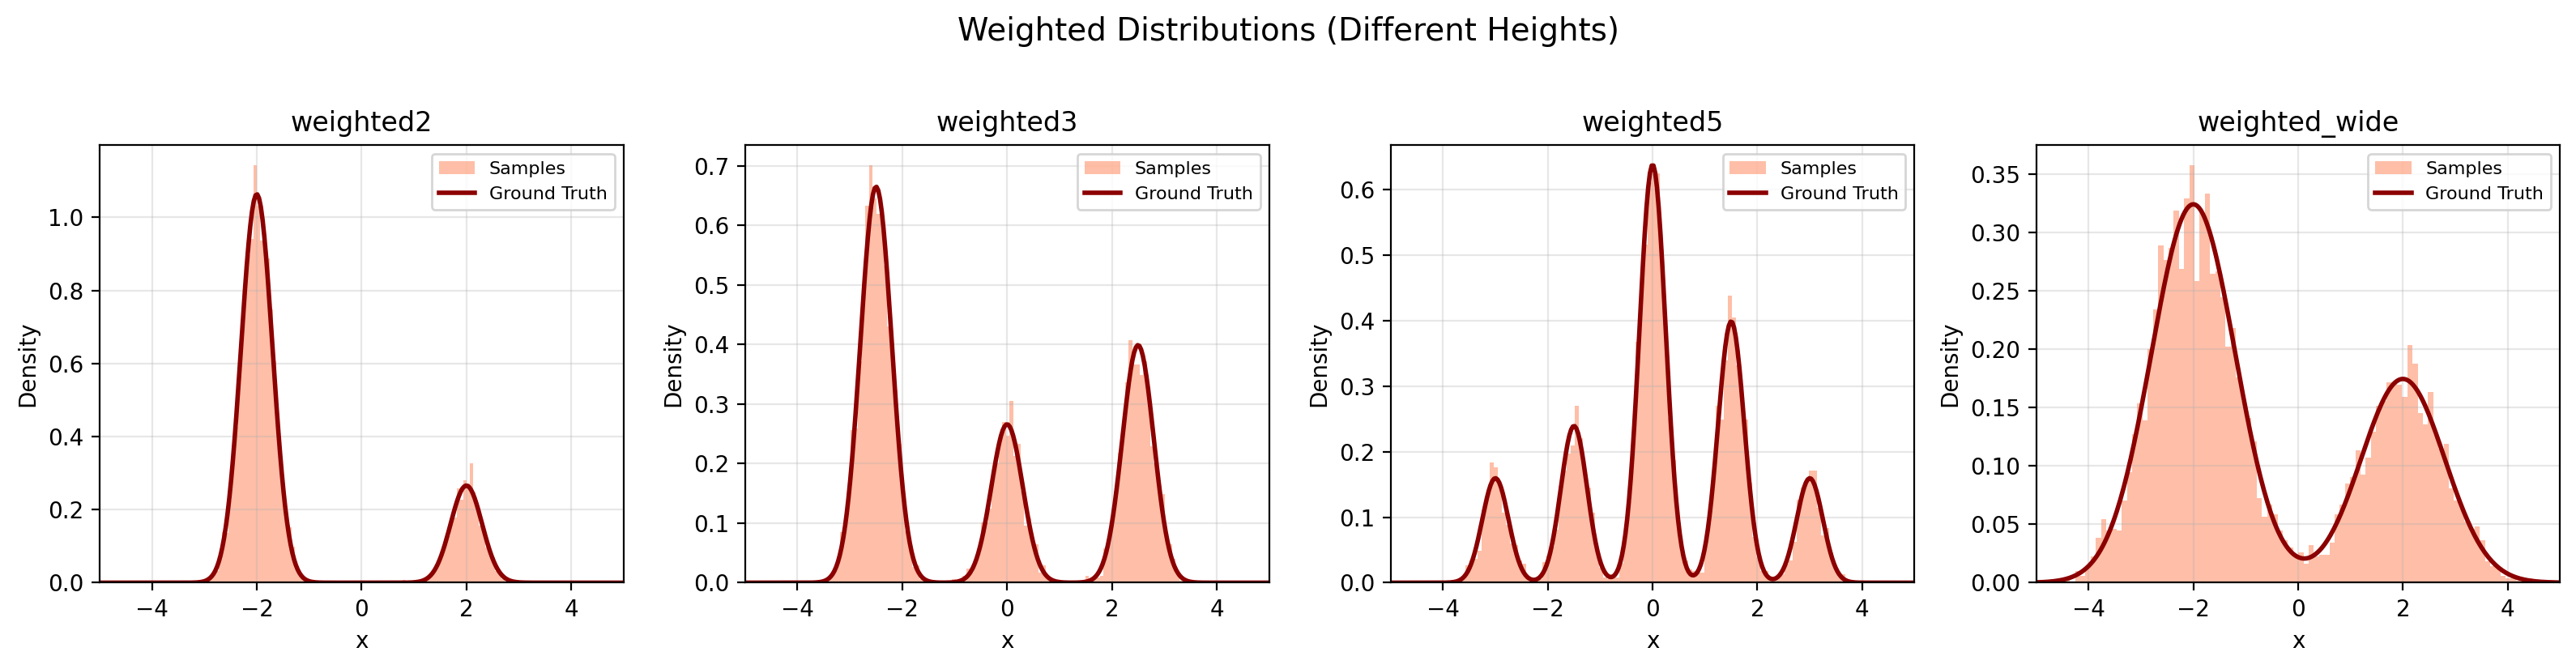

In [4]:
# Visualize available distributions
datasets_equal = ['2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide']
datasets_weighted = ['weighted2', 'weighted3', 'weighted5', 'weighted_wide']

# Plot equal weight distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Equal Weight Distributions', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_equal):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'r-', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot weighted distributions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Weighted Distributions (Different Heights)', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_weighted):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, color='coral', label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'darkred', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Simple network for 1D

First design a simple network (like an MLP) to model the 1D data, remember to also include the time embeddings.

In [5]:
class TimeMLP(nn.Module):
    """
    A simple MLP for 1D diffusion that takes (x, t) and outputs noise prediction.
    Robustly handles input shapes of (B, 1) or (B, 1, 1).
    """
    def __init__(self, hidden_dim=64, time_embed_dim=16):
        super().__init__()
        
        # 1. Time Embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # 2. Main Network
        self.net = nn.Sequential(
            nn.Linear(1 + time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, t):
        # x shape might be [batch, 1] or [batch, 1, 1]
        # t shape is [batch]
        
        # Flatten x to [batch, 1] to be safe
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
            
        # Ensure t is [batch, 1]
        if t.dim() == 0: t = t.unsqueeze(0)
        if t.dim() == 1: t = t.unsqueeze(-1)
        
        # Embed time
        t_emb = self.time_embed(t.float()) 
        
        # Concatenate [batch, 1] + [batch, 16] -> [batch, 17]
        xt = torch.cat([x, t_emb], dim=-1)
        
        return self.net(xt)

## 3. DDPM algorithm implementation

Implement the forward process, backward process, loss calculation and the sampling process of the DDPM algorithm. You can feel free to follow the structure of src/methods/ddpm.py or directly import your implementation from there.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from abc import ABC, abstractmethod
from typing import Any, Dict, Tuple, cast

# ==============================================================================
# 1. BaseMethod (Originally from src/methods/base.py)
# ==============================================================================

class BaseMethod(nn.Module, ABC):
    """
    Abstract base class for generative modeling methods.
    """

    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
    ):
        super().__init__()
        self.model = model
        self.device = device

    @abstractmethod
    def compute_loss(
        self,
        x: torch.Tensor,
        **kwargs: Any
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """Compute the training loss for a batch of data."""
        pass

    @abstractmethod
    def sample(
        self,
        n_samples: int,
        size: Tuple[int, ...],
        **kwargs: Any
    ) -> torch.Tensor:
        """Generate samples."""
        pass

    def forward(
        self,
        x: torch.Tensor,
        **kwargs: Any
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """Forward pass typically computes the loss."""
        return self.compute_loss(x, **kwargs)

    def to(self, *args: Any, **kwargs: Any) -> "BaseMethod":
        """Move the method to a device."""
        super().to(*args, **kwargs)
        self.device = args[0] if args else kwargs.get("device", self.device)
        return self


# ==============================================================================
# 2. DDPM Class (Originally from src/methods/ddpm.py)
# ==============================================================================

class DDPM(BaseMethod):
    """Denoising Diffusion Probabilistic Models."""

    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        num_timesteps: int,
        beta_start: float,
        beta_end: float,
    ):
        super().__init__(model, device)

        self.num_timesteps = int(num_timesteps)
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Create beta schedule (linear)
        betas = torch.linspace(
            beta_start,
            beta_end,
            num_timesteps,
            device=device
        )

        # Precompute useful values
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        # Pad with 1.0 for the previous step calculation (needed for posterior variance)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1, device=device), alphas_cumprod[:-1]]
        )

        # Register buffers (not trainable parameters)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        # posterior_variance = beta * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.register_buffer("posterior_variance", posterior_variance)
        
        # Log calculation clipped because the posterior variance is 0 at the beginning
        self.register_buffer(
            "posterior_log_variance_clipped",
            torch.log(torch.clamp(posterior_variance, min=1e-20))
        )

    def compute_loss(
        self,
        x: torch.Tensor,
        **kwargs: Any
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Compute DDPM training loss (MSE between predicted noise and actual noise).
        """
        batch_size = x.shape[0]

        # 1. Sample random timesteps t ~ U[0, T-1]
        t = torch.randint(
            0,
            self.num_timesteps,
            (batch_size,),
            device=self.device
        )

        # 2. Sample noise epsilon ~ N(0, I)
        noise = torch.randn_like(x)

        # 3. Compute x_t (Forward Process)
        # x_t = sqrt(alpha_bar) * x_0 + sqrt(1 - alpha_bar) * epsilon
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        
        x_t = sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise

        # 4. Predict noise using the model
        pred_noise = self.model(x_t, t)

        # 5. Compute MSE Loss
        loss = F.mse_loss(pred_noise, noise)
        
        return loss, {"mse": loss.item()}

    @torch.no_grad()
    def sample(
        self,
        n_samples: int,
        size: Tuple[int, ...],
        **kwargs: Any
    ) -> torch.Tensor:
        """
        Generate samples using the reverse diffusion process.
        """
        self.model.eval()
        
        # Start from pure noise x_T ~ N(0, I)
        x = torch.randn((n_samples, *size), device=self.device)
        
        # Iteratively denoise: x_T -> x_{T-1} -> ... -> x_0
        for t in reversed(range(0, self.num_timesteps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x = self.reverse_process(x, t_batch)
            
        self.model.train()
        return x

    @torch.no_grad()
    def reverse_process(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor
    ) -> torch.Tensor:
        """
        Single step of the reverse process: x_t -> x_{t-1}
        """
        # 1. Predict noise
        model_out = self.model(x_t, t)
        
        # 2. Calculate the mean for the posterior distribution
        # mu = (1/sqrt(alpha)) * (x_t - (beta / sqrt(1-alpha_bar)) * epsilon)
        betas_t = self._extract(self.betas, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        sqrt_recip_alphas_t = self._extract(self.sqrt_recip_alphas, t, x_t.shape)
        
        model_mean = sqrt_recip_alphas_t * (
            x_t - (betas_t * model_out / sqrt_one_minus_alphas_cumprod_t)
        )
        
        # 3. Calculate the variance (sigma^2 = posterior_variance)
        posterior_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        
        # 4. Sample z ~ N(0, I)
        noise = torch.randn_like(x_t)
        
        # 5. Mask noise for t=0 (no noise at the final step)
        mask = (t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1)))
        
        # 6. x_{t-1} = mu + sigma * z
        x_prev = model_mean + mask * (0.5 * posterior_log_variance).exp() * noise
        return x_prev

    def _extract(self, a, t, x_shape):
        """
        Helper function to extract coefficients at specific timesteps t 
        and reshape them for broadcasting against x.
        """
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

## 4. Training

Write your training loop here (or you can combine it above, whichever way is easier for you)

Loss: 0.6161: 100%|██████████| 2000/2000 [00:01<00:00, 1669.46it/s]


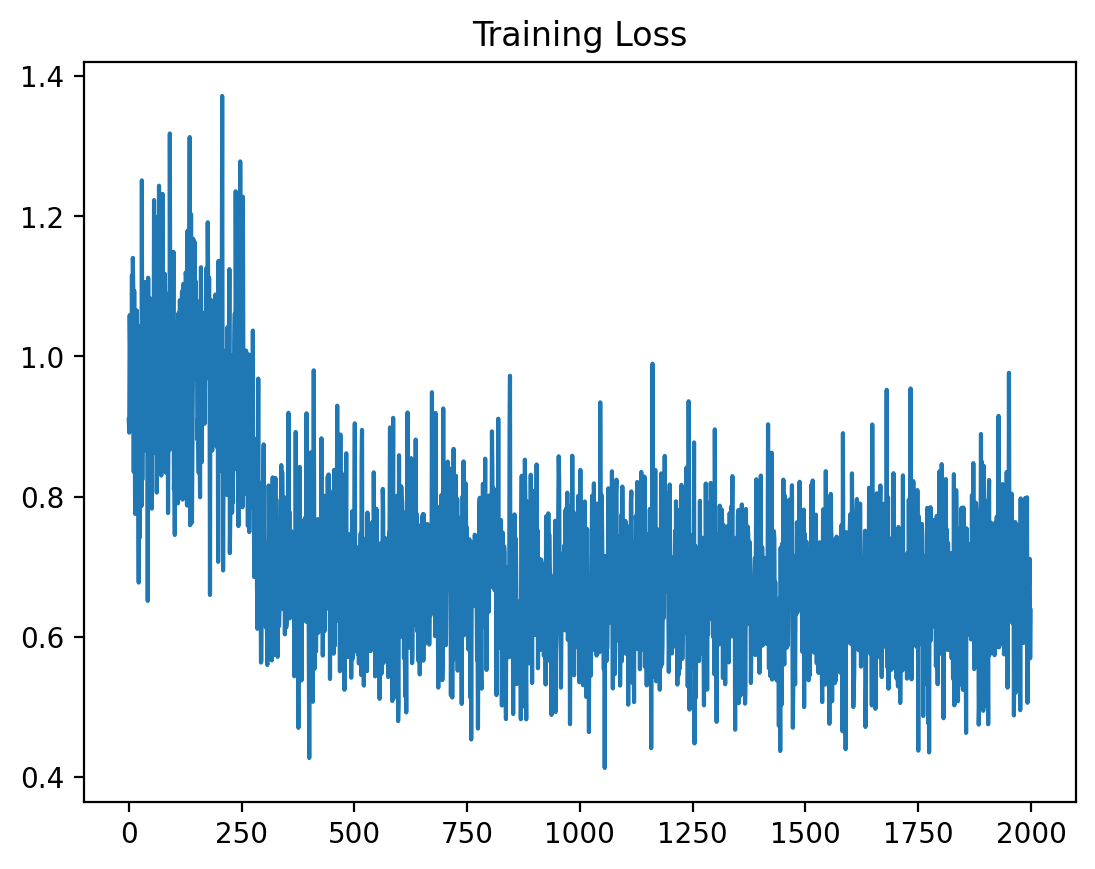

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Configuration ---
NUM_STEPS = 2000
BATCH_SIZE = 128
LR = 1e-3
NUM_TIMESTEPS = 50 # Keep it small for 1D playground

# --- 2. Init Model & DDPM ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeMLP().to(device)
ddpm = DDPM(
    model=model, 
    device=device,
    num_timesteps=NUM_TIMESTEPS,
    beta_start=1e-4,
    beta_end=0.02
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- 3. Training Loop ---
loss_history = []
pbar = tqdm(range(NUM_STEPS))

for step in pbar:
    optimizer.zero_grad()
    
    # Get batch
    x_0 = get_1d_data(BATCH_SIZE).to(device)
    
    # Compute Loss (Forward process + Prediction)
    loss, stats = ddpm.compute_loss(x_0)
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if step % 100 == 0:
        pbar.set_description(f"Loss: {loss.item():.4f}")

# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

## 5. Visualize Samples

Visualize your learned distributions and compare them with the ground truth. I have left my visualization results for you as reference.

Sampling...


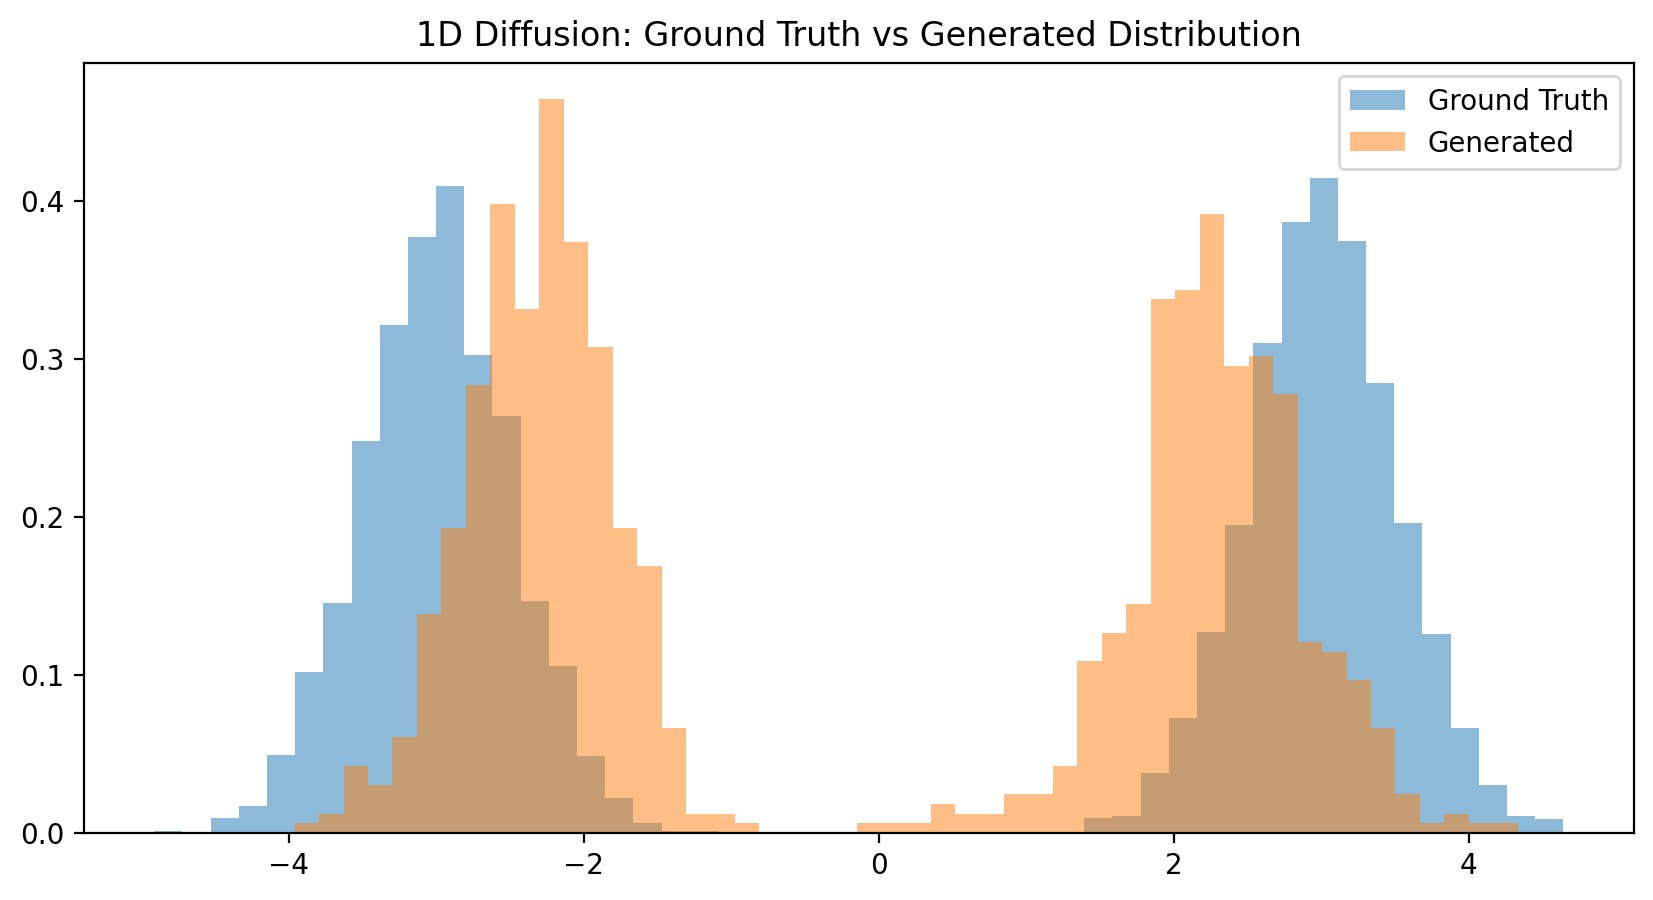

In [17]:
# --- 4. Sampling (Sanity Check) ---
print("Sampling...")
# Sample from the model
# New (correct for 1D)
samples = ddpm.sample(n_samples=1000, size=(1,))
samples = samples.cpu().squeeze().numpy()

# Plot Ground Truth vs Generated
plt.figure(figsize=(10, 5))
plt.hist(get_1d_data(5000).squeeze().numpy(), bins=50, alpha=0.5, label="Ground Truth", density=True)
plt.hist(samples, bins=50, alpha=0.5, label="Generated", density=True)
plt.legend()
plt.title("1D Diffusion: Ground Truth vs Generated Distribution")
plt.show()

## 6. Visualize Sampling Trajectories

Besides visualizing the final results, you can also visualize the entire sampling trajectory in order to get a better understanding of the process. Here I also left you my visualization results as an example.

In [21]:
def plot_trajectory(trajectory, title, n_points=1000, n_steps_show=10, dataset_name=None):
    """Plot sampling trajectory."""
    n_total_steps = len(trajectory)
    step_indices = np.linspace(0, n_total_steps-1, n_steps_show, dtype=int)
    
    fig, axes = plt.subplots(1, n_steps_show, figsize=(2*n_steps_show, 3))
    
    # Prepare ground truth for final step if dataset name provided
    if dataset_name is not None:
        x_line = np.linspace(-5, 5, 300)
        gt_density = get_ground_truth_density(dataset_name, x_line)
    
    for ax, step_idx in zip(axes, step_indices):
        points = trajectory[step_idx][:n_points]
        ax.hist(points.numpy(), bins=50, density=True, alpha=0.7)
        
        # Overlay ground truth on final step
        if dataset_name is not None and step_idx == step_indices[-1]:
            ax.plot(x_line, gt_density, 'r-', linewidth=2, alpha=0.8)
        
        ax.set_xlim(-5, 5)
        ax.set_ylim(0, 1.2)
        ax.set_title(f't={step_idx}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        if ax == axes[0]:
            ax.set_ylabel('Density', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()